In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.stats.multicomp as mc
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
seed = 42

In [2]:
# I. Import data
wholesale = pd.read_csv('Wholesale customers data.csv')
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
# II. Data Understanding
# Investigate if there is any missing values
wholesale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
# Summarize statistics for each variables
wholesale.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
# Tukey-HSD to test the mean expenditure difference between 
# categories in 2 groups Channel, Region
def test_ANOVA(categorical_variable, df=wholesale):
    categorical_variables = ['Channel', 'Region']
    for col in [col for col in df.columns if col not in categorical_variables]:
        comp = mc.MultiComparison(df[col], df[categorical_variable])
        post_hoc_res = comp.tukeyhsd()
        tukeyHSD_df = pd.DataFrame(post_hoc_res.summary())
        tukeyHSD_df.columns = tukeyHSD_df.iloc[0]
        tukeyHSD_df = tukeyHSD_df[1:]
        for row in tukeyHSD_df.values:
            if str(row[6]) == 'False':
                result = "NOT significant"
            else:
                result = "significant"
            print(f"Mean diff of {row[2]} in {col} between {row[0]} and {row[1]} in {categorical_variable} was {result}.")
        print("------------------------------------------------------")

In [6]:
# run Tukey-HSD test for Region variable
test_ANOVA('Region')

Mean diff of -1214.0464 in Fresh between 1 and 2 in Region was NOT significant.
Mean diff of 1431.7442 in Fresh between 1 and 3 in Region was NOT significant.
Mean diff of 2645.7907 in Fresh between 2 and 3 in Region was NOT significant.
------------------------------------------------------
Mean diff of -398.2454 in Milk between 1 and 2 in Region was NOT significant.
Mean diff of 490.6699 in Milk between 1 and 3 in Region was NOT significant.
Mean diff of 888.9152 in Milk between 2 and 3 in Region was NOT significant.
------------------------------------------------------
Mean diff of 1815.5178 in Grocery between 1 and 2 in Region was NOT significant.
Mean diff of 493.286 in Grocery between 1 and 3 in Region was NOT significant.
Mean diff of -1322.2318 in Grocery between 2 and 3 in Region was NOT significant.
------------------------------------------------------
Mean diff of 1045.024 in Frozen between 1 and 2 in Region was NOT significant.
Mean diff of -55.7427 in Frozen between 1 an

In [7]:
# run Tukey-HSD test for Channel variable
test_ANOVA('Channel')

Mean diff of -4571.2365 in Fresh between 1 and 2 in Channel was significant.
------------------------------------------------------
Mean diff of 7264.7752 in Milk between 1 and 2 in Channel was significant.
------------------------------------------------------
Mean diff of 12360.7145 in Grocery between 1 and 2 in Channel was significant.
------------------------------------------------------
Mean diff of -2095.639 in Frozen between 1 and 2 in Channel was significant.
------------------------------------------------------
Mean diff of 6478.9466 in Detergents_Paper between 1 and 2 in Channel was significant.
------------------------------------------------------
Mean diff of 337.4802 in Delicassen between 1 and 2 in Channel was NOT significant.
------------------------------------------------------


In [8]:
# Remove Region and Channel variables
df = wholesale.drop(columns=['Region', 'Channel'])

<Axes: >

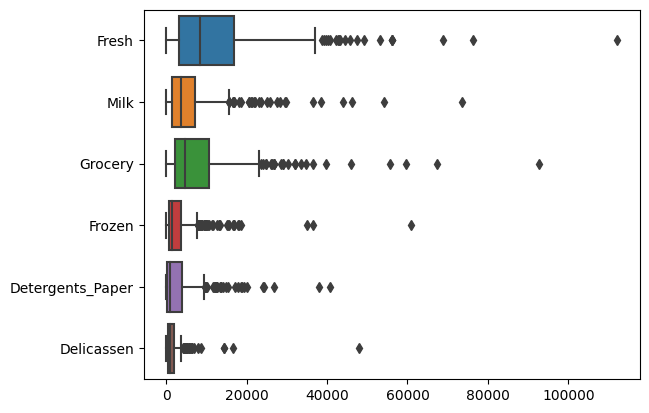

In [9]:
# show the boxplots for 6 numerical variables
columns = list(df.columns)
sns.boxplot(data=df[[col for col in columns 
                     if col not in ['Channel', 'Region']]], orient="h")

In [10]:
# II. Data preprocessing
# log transform variables
log_columns = ['log_' + col for col in columns]
log_df = {}
for col in columns:
    log_col = np.log(df[col]).tolist()
    log_df['log_' + col] = log_col
log_df = pd.DataFrame(log_df)

<Axes: >

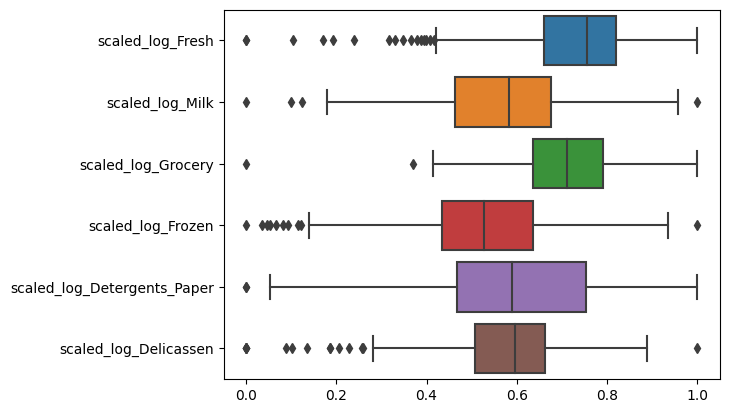

In [11]:
# MinMax scaling variables
scaled_log_columns = ['scaled_' + col for col in log_columns]
scaler3 = MinMaxScaler()
scaler3.fit(log_df)
scaled_log_df = scaler3.transform(log_df)
scaled_log_df = pd.DataFrame(scaled_log_df, columns=scaled_log_columns)
sns.boxplot(data=scaled_log_df[[col for col in scaled_log_columns 
                     if col not in ['scaled_log_Channel', 'scaled_log_Region']]], orient="h")

In [12]:
# form the new data with transformed variables
merged_df = pd.DataFrame(np.column_stack((df.values,  
                                          log_df.values, 
                                          scaled_log_df.values)), 
                         columns=columns+log_columns+scaled_log_columns)
merged_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,log_Fresh,log_Milk,log_Grocery,log_Frozen,log_Detergents_Paper,log_Delicassen,scaled_log_Fresh,scaled_log_Milk,scaled_log_Grocery,scaled_log_Frozen,scaled_log_Detergents_Paper,scaled_log_Delicassen
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931,0.792887,0.718009,0.757507,0.275354,0.713634,0.630253
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119,0.737313,0.720208,0.780276,0.545723,0.735510,0.659511
2,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504,0.727332,0.705239,0.759068,0.585620,0.742394,0.812973
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853,0.797253,0.427833,0.701127,0.711219,0.538941,0.660206
4,22615.0,5410.0,7198.0,3915.0,1777.0,5185.0,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525,0.847922,0.637521,0.752748,0.648109,0.670702,0.770203


In [13]:
# III. Model fitting
# develop helper functions
def show_boxplots_by_cluster(merged_df):
    removed_cols = [col for col in merged_df.columns 
                    if ('Channel' in col) 
                    or ('Region' in col) 
                    or ('cluster' in col)]
    fig, ax = plt.subplots(2, 3, figsize=(10, 6))
    n_row = 0
    n_col = 0
    for col in merged_df.columns:
        if (col not in removed_cols):
            data = []
            for cluster in np.unique(merged_df['cluster']):
                sub = (merged_df[col][merged_df['cluster']==cluster]/1000).tolist() # thousands USD
                data.append((sub))
            ax[n_row][n_col].boxplot(data, labels=np.unique(merged_df['cluster']))
            ax[n_row][n_col].set_ylabel(col)
            if n_col < 2:
                n_col += 1
            else:
                n_row += 1
                n_col = 0
    plt.show()

In [14]:
def calculate_inertia(merged_df):
    agg_df = merged_df.groupby(by='cluster', as_index=False).mean()
    inertia = 0
    for nth in range(len(merged_df)):
        row = merged_df.iloc[nth].values
        cluster = row[-1]
        obs = row[:-1]
        centroid = agg_df[agg_df['cluster'] == cluster].iloc[0].values[1:]
        inertia += sum((obs-centroid)**2)
    return inertia

Params sets meeting [Number of obs per cluster] for KMeans Clustering:
[2, 3, 4, 5]


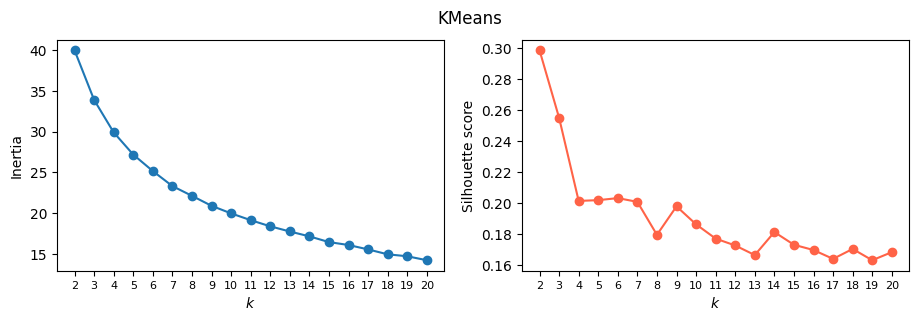

In [15]:
# KMeans Clustering
# experiment KMeans with different scenarios
def experiment_kmeans(variables=scaled_log_columns, clusters_range = range(2, 21, 1), 
                      obs_threshold = 44):
    # find parameters set for KMeans Clustering, meeting the minimum 
    # observations in each group
    params = []
    inertias = []
    silhouette_scores = []
    X = merged_df[variables].values
    labels = []
    for n_clusters in clusters_range:
        km = KMeans(n_clusters=n_clusters, random_state=seed)
        km.fit(X)
        merged_df['cluster'] = km.labels_
        labels.append(km.labels_)
        
        inertia = calculate_inertia(merged_df[variables+['cluster']])
        inertias.append(inertia)
        silhouette_scores.append(silhouette_score(X, km.labels_))
        
        agg_df = merged_df.groupby(by=['cluster'], as_index=False).agg(
            cnt = ('cluster', 'count')
        )
        if (len(agg_df[agg_df['cnt'] < obs_threshold]) > 0):
            continue
        params.append(n_clusters)
    print(f"Params sets meeting [Number of obs per cluster] for KMeans Clustering:\n{params}")
    
    fig, ax = plt.subplots(1, 2, figsize=(11, 3))
    ax[0].plot(clusters_range, inertias, "o-")
    ax[0].set_xticks(clusters_range)
    ax[0].set_xticklabels(labels=clusters_range, fontsize=8)
    ax[0].set_xlabel("$k$", fontsize=10)
    ax[0].set_ylabel("Inertia", fontsize=10)
    
    ax[1].plot(clusters_range, silhouette_scores, "o-", color="tomato")
    ax[1].set_xticks(clusters_range)
    ax[1].set_xticklabels(labels=clusters_range, fontsize=8)
    ax[1].set_xlabel("$k$", fontsize=10)
    ax[1].set_ylabel("Silhouette score", fontsize=10)
    fig.suptitle("KMeans")
    plt.show()
    return X, labels, silhouette_scores
X, labels, silhouette_scores = experiment_kmeans()

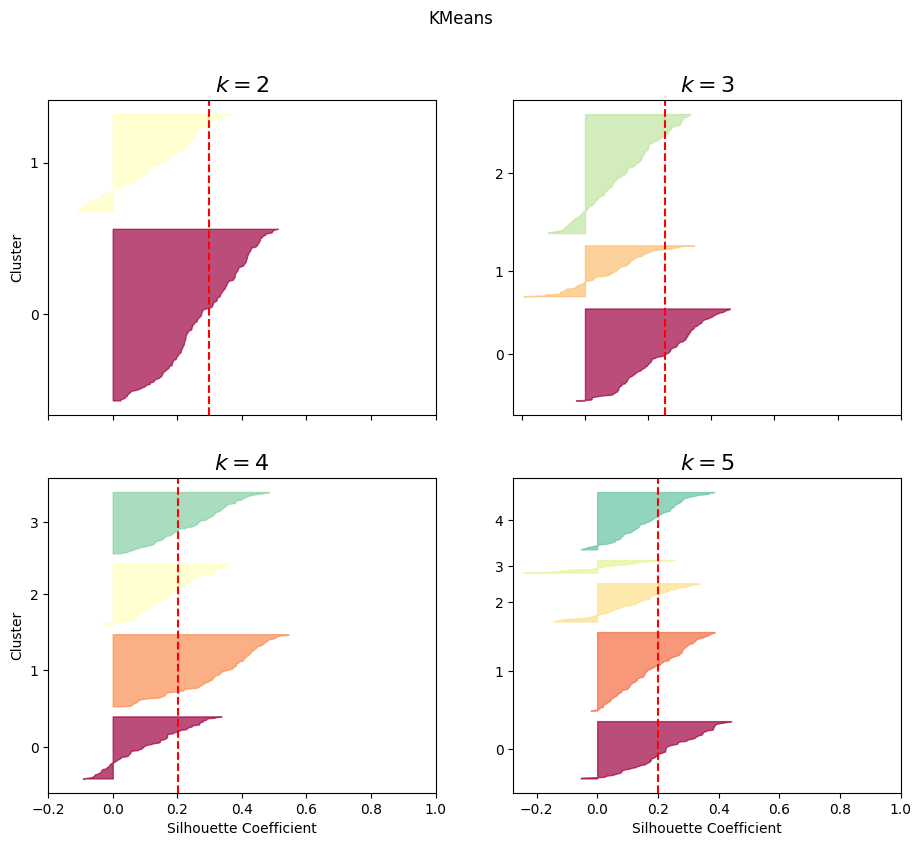

In [16]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = labels[k-1]
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 3, 4, 5):
        plt.gca().set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    if k in (2, 4):
        plt.ylabel("Cluster")
    if k in (4, 5):
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.suptitle("KMeans")
plt.show()

   cluster  cnt
0        0  113
1        1   63
2        2  146
3        3  118


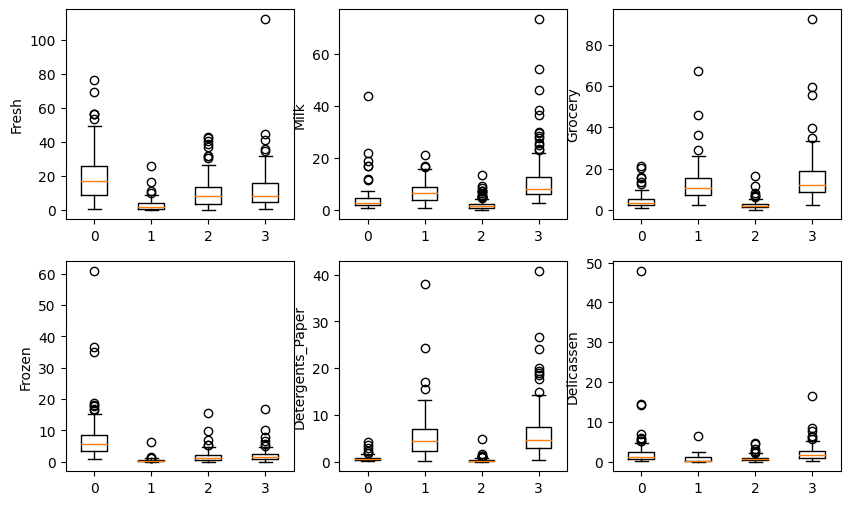

In [17]:
# clusters number of 4 is selected for KMeans
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(merged_df[scaled_log_columns])
merged_df['cluster'] = km.labels_
agg_df = merged_df.groupby(by=['cluster'], as_index=False).agg(
    cnt = ('cluster', 'count')
)
print(agg_df)
show_boxplots_by_cluster(merged_df[columns + ['cluster']])

Params sets meeting [Number of obs per cluster] for Hierarchical Clustering:
[(2, 'complete')]


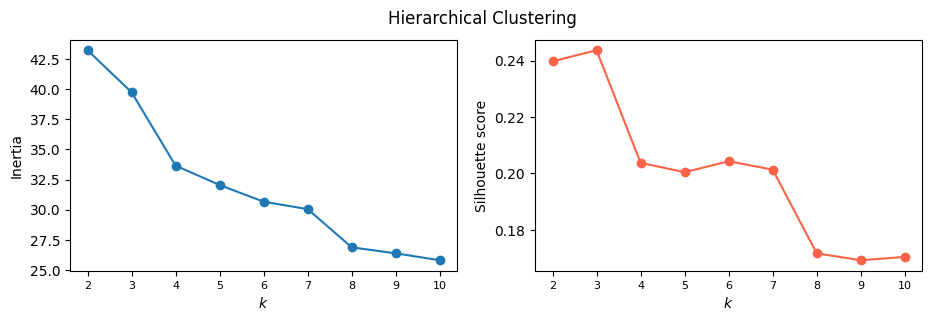

In [18]:
# Hierarchial Clustering
# experiment Hierarchial Clustering with different scenarios
def experiment_hc(variables=scaled_log_columns, 
                  clusters_range = np.arange(2, 11, 1), 
                  linkages = ['complete'], 
                  obs_threshold = 44):
    # find parameters set for Hierarchial Clustering, meeting the minimum 
    # observations in each group
    X = merged_df[variables].values
    params = []
    inertias = []
    silhouette_scores = []
    for n_clusters in clusters_range:
        for linkage in linkages:
            hc = AgglomerativeClustering(n_clusters=n_clusters, 
                                 affinity='euclidean', 
                                 memory=None, 
                                 connectivity=None, 
                                 compute_full_tree='auto', 
                                 linkage=linkage,
                                 distance_threshold=None, 
                                 compute_distances=False)
            hc.fit(merged_df[variables])
            merged_df['cluster'] = hc.labels_
            
            inertia = calculate_inertia(merged_df[variables+['cluster']])
            inertias.append(inertia)
            silhouette_scores.append(silhouette_score(X, hc.labels_))
            
            agg_df = merged_df.groupby(by=['cluster'], as_index=False).agg(
                cnt = ('cluster', 'count')
            )
            if (len(agg_df[agg_df['cnt'] < obs_threshold]) > 0):
                continue
            params.append((n_clusters, linkage))
    print(f"Params sets meeting [Number of obs per cluster] for Hierarchical Clustering:\n{params}")
    
    fig, ax = plt.subplots(1, 2, figsize=(11, 3))
    ax[0].plot(clusters_range, inertias, "o-")
    ax[0].set_xticks(clusters_range)
    ax[0].set_xticklabels(labels=clusters_range, fontsize=8)
    ax[0].set_xlabel("$k$", fontsize=10)
    ax[0].set_ylabel("Inertia", fontsize=10)
    
    ax[1].plot(clusters_range, silhouette_scores, "o-", color="tomato")
    ax[1].set_xticks(clusters_range)
    ax[1].set_xticklabels(labels=clusters_range, fontsize=8)
    ax[1].set_xlabel("$k$", fontsize=10)
    ax[1].set_ylabel("Silhouette score", fontsize=10)
    fig.suptitle("Hierarchical Clustering")
    plt.show()
    
experiment_hc()

   cluster  cnt
0        0  218
1        1  222


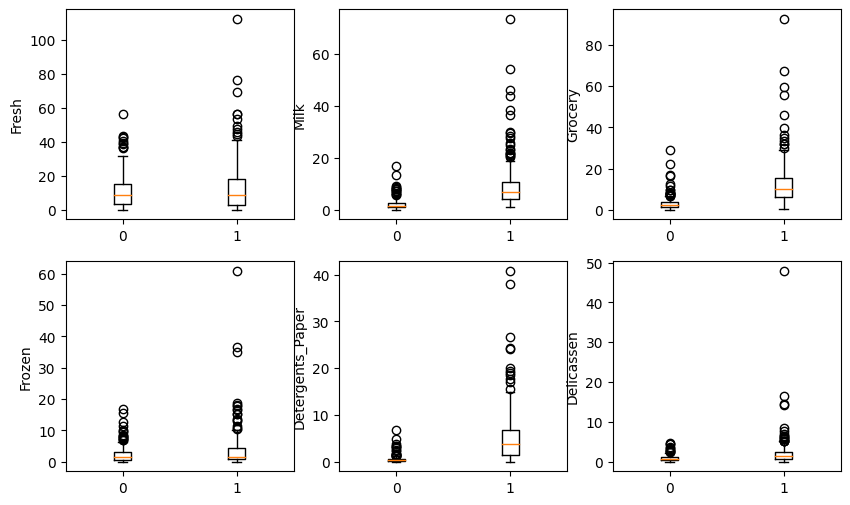

In [19]:
# clusters number of 2 is selected for Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             memory=None, 
                             connectivity=None, 
                             compute_full_tree='auto', 
                             linkage='complete', # {‘ward’, ‘complete’, ‘average’, ‘single’}
                             distance_threshold=None, 
                             compute_distances=False)
hc.fit(merged_df[scaled_log_columns])
merged_df['cluster'] = hc.labels_
agg_df = merged_df.groupby(by=['cluster'], as_index=False).agg(
    cnt = ('cluster', 'count')
)
print(agg_df)
show_boxplots_by_cluster(merged_df[columns + ['cluster']])

Params sets meeting [Number of obs per cluster] for DBSCAN:
[(0.15000000000000002, 20), (0.15000000000000002, 25), (0.15000000000000002, 30), (0.2, 50), (0.2, 55), (0.2, 60), (0.2, 65)]


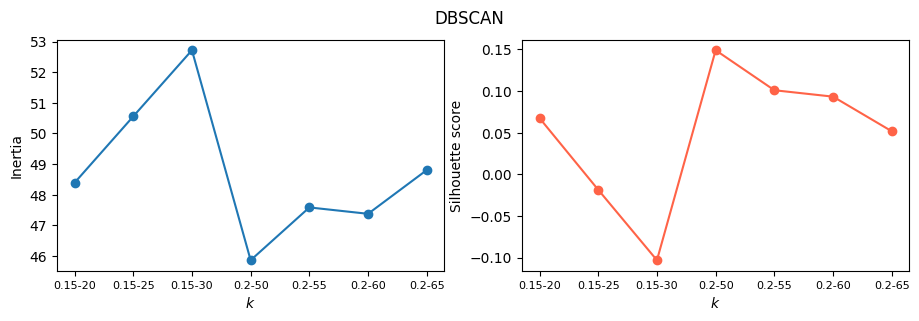

In [20]:
# DBSCAN
# experiment DBSCAN with different scenarios
def experiment_dbscan(variables=scaled_log_columns, 
                      eps_range = np.arange(0.05, 2.5, 0.05), # minmaxscaler
                      # eps_range = np.arange(100, 10000, 200), # original
                      # eps_range = np.arange(0.1, 10, 0.1), # log
                      min_samples_range = np.arange(5, 105, 5), 
                      obs_threshold = 44,
                      min_groups = 3):
    # find parameters set for DBSCAN, meeting the minimum groups and
    # minimum observations in each group
    X = merged_df[variables].values
    params = []
    inertias = []
    silhouette_scores = []
    clusters_range = []
    for eps in eps_range:
        for min_samples in min_samples_range:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            db.fit(merged_df[variables])
            merged_df['cluster'] = db.labels_
            
            if len(np.unique(db.labels_)) == 1:
                continue
            
            agg_df = merged_df.groupby(by=['cluster'], as_index=False).agg(
                cnt = ('cluster', 'count')
            )
            if (len(agg_df[agg_df['cnt'] < obs_threshold]) > 0) or (len(agg_df) < min_groups):
                continue
            params.append((eps, min_samples))
            
            clusters_range.append(f"{round(eps,2)}-{round(min_samples,0)}")
            inertia = calculate_inertia(merged_df[variables+['cluster']])
            inertias.append(inertia)
            silhouette_scores.append(silhouette_score(X, db.labels_))
            
    print(f"Params sets meeting [Number of obs per cluster] for DBSCAN:\n{params}")
    
    fig, ax = plt.subplots(1, 2, figsize=(11, 3))
    ax[0].plot(clusters_range, inertias, "o-")
    ax[0].set_xticks(clusters_range)
    ax[0].set_xticklabels(labels=clusters_range, fontsize=8)
    ax[0].set_xlabel("$k$", fontsize=10)
    ax[0].set_ylabel("Inertia", fontsize=10)
    
    ax[1].plot(clusters_range, silhouette_scores, "o-", color="tomato")
    ax[1].set_xticks(clusters_range)
    ax[1].set_xticklabels(labels=clusters_range, fontsize=8)
    ax[1].set_xlabel("$k$", fontsize=10)
    ax[1].set_ylabel("Silhouette score", fontsize=10)
    fig.suptitle("DBSCAN")
    plt.show()
    
experiment_dbscan()

   cluster  cnt
0       -1  153
1        0  119
2        1  168


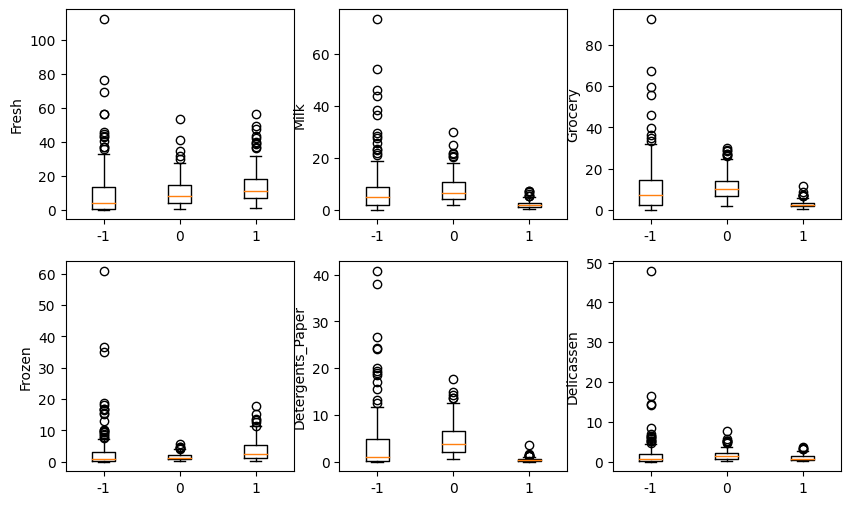

In [21]:
# eps=0.2 and min_samples=50 are selected for DNSCAN
db = DBSCAN(eps=0.2, min_samples=50) 
db.fit(merged_df[scaled_log_columns])
merged_df['cluster'] = db.labels_
agg_df = merged_df.groupby(by=['cluster'], as_index=False).agg(
    cnt = ('cluster', 'count')
)
print(agg_df)
show_boxplots_by_cluster(merged_df[columns + ['cluster']])

In [22]:
# add cluster labels from 3 algorithms to wholesale data
wholesale['cluster1'] = km.labels_
wholesale['cluster2'] = hc.labels_
wholesale['cluster3'] = db.labels_
wholesale['Region-Channel'] = [str(pair[0]) + '-' + str(pair[1]) 
                               for pair in wholesale[['Region', 'Channel']].values]

In [23]:
def divided_by_1000(wholesale):
    columns = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
    for col in columns:
        wholesale[col] = wholesale[col]/1000
    return wholesale

In [24]:
def generate_lineplots_categorical_variable(column, cluster, wholesale):
    benchmark = wholesale.groupby(by=column, as_index=False).agg(
        benchmark = (column, "count")
    )
    benchmark["benchmark"] = benchmark["benchmark"]/len(wholesale)
    total = wholesale.groupby(by=[cluster], as_index=False).agg(
        cnt = (cluster, "count")
    )
    detail = wholesale.groupby(by=[cluster, column], as_index=False).agg(
        cnt = (column, "count")
    )
    detail = pd.pivot_table(data=detail, values="cnt", index=cluster, columns=column, 
                            aggfunc='sum', fill_value=0).reset_index()
    detail = pd.melt(detail, id_vars=[cluster], value_vars=benchmark[column].tolist())
    detail = detail.merge(total, how="inner", on=cluster)
    detail['value'] = detail['value']/detail['cnt']
    detail = detail[[cluster, column, "value"]]
    detail = pd.pivot_table(data=detail, values="value", index=column, columns=cluster, 
                            aggfunc='sum', fill_value=0).reset_index()
    detail = detail.merge(benchmark, how="inner", on=column)
    detail.index = detail[column].astype('str')
    return detail

In [25]:
def visualize_clusters(wholesale, labels):
    data = divided_by_1000(wholesale.copy())
    hue=labels
    titles = {"cluster1": "KMeans", "cluster2": "Hierarchial Clustering", "cluster3": "DBSCAN"}
    channel = generate_lineplots_categorical_variable('Channel', hue, wholesale)
    region = generate_lineplots_categorical_variable('Region', hue, wholesale)
    regionXchannel = generate_lineplots_categorical_variable('Region-Channel', hue, wholesale)
    alpha = 0.7
    scatter_pallete = "deep"
    line_pallete = ['red', 'blue', 'purple', 'grey', 'green']
    lines_channel = channel.columns.tolist()
    lines_channel.remove('Channel')
    lines_region = region.columns.tolist()
    lines_region.remove('Region')
    lines_regionXchannel = regionXchannel.columns.tolist()
    lines_regionXchannel.remove('Region-Channel')
    fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    fig.suptitle(titles[hue])
    sns.lineplot(ax=ax[0][0], data=region[lines_region], 
                 palette=line_pallete, alpha=alpha)
    sns.lineplot(ax=ax[0][1], data=channel[lines_channel], 
                 palette=line_pallete, alpha=alpha)
    sns.lineplot(ax=ax[0][2], data=regionXchannel[lines_regionXchannel], 
                 palette=line_pallete, alpha=alpha)
    sns.scatterplot(ax=ax[1][0], data=data, x="Frozen", y="Fresh", 
                    hue=hue, palette=scatter_pallete, alpha=alpha)
    sns.scatterplot(ax=ax[1][1], data=data, x="Milk", y="Grocery", 
                    hue=hue, palette=scatter_pallete, alpha=alpha)
    sns.scatterplot(ax=ax[1][2], data=data, x="Detergents_Paper", y="Delicassen", 
                    hue=hue, palette=scatter_pallete, alpha=alpha)

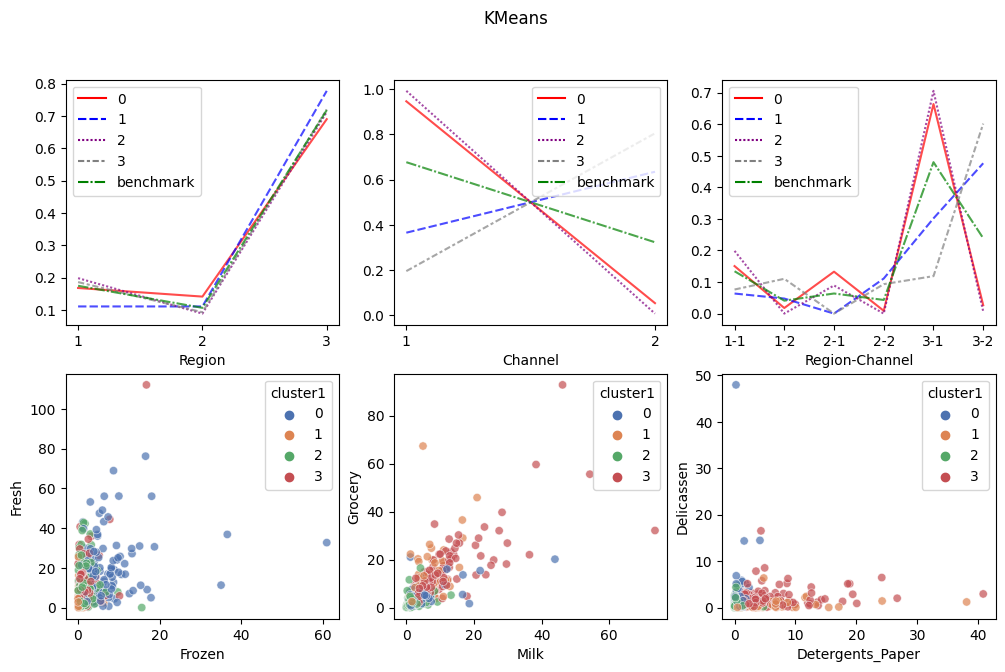

In [26]:
# visualize clustering results of KMeans
visualize_clusters(wholesale, "cluster1")

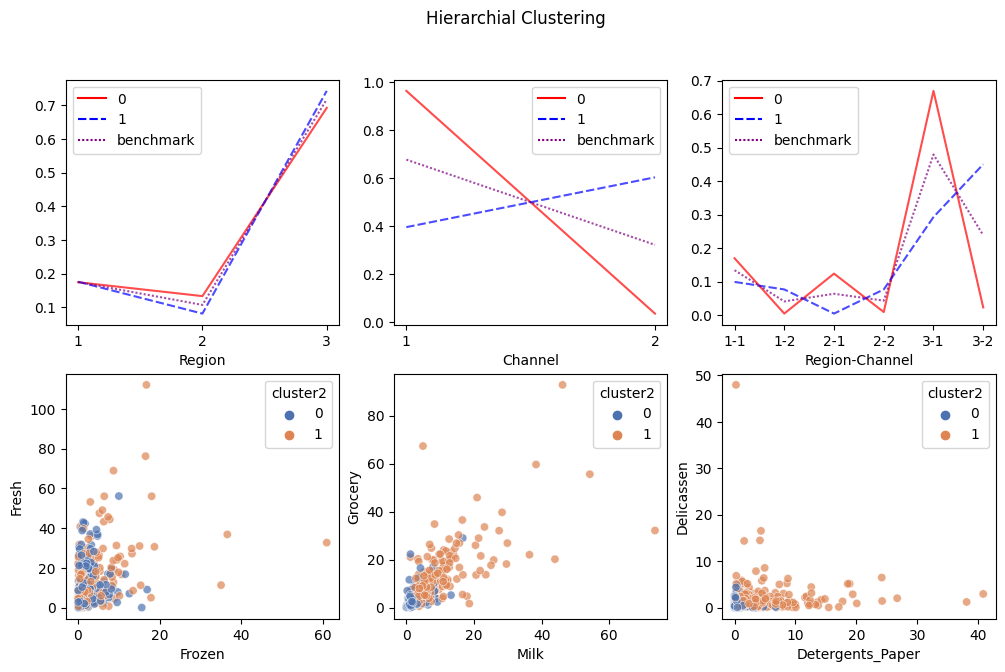

In [27]:
# visualize clustering results of Hierarchical Clustering
visualize_clusters(wholesale, "cluster2")

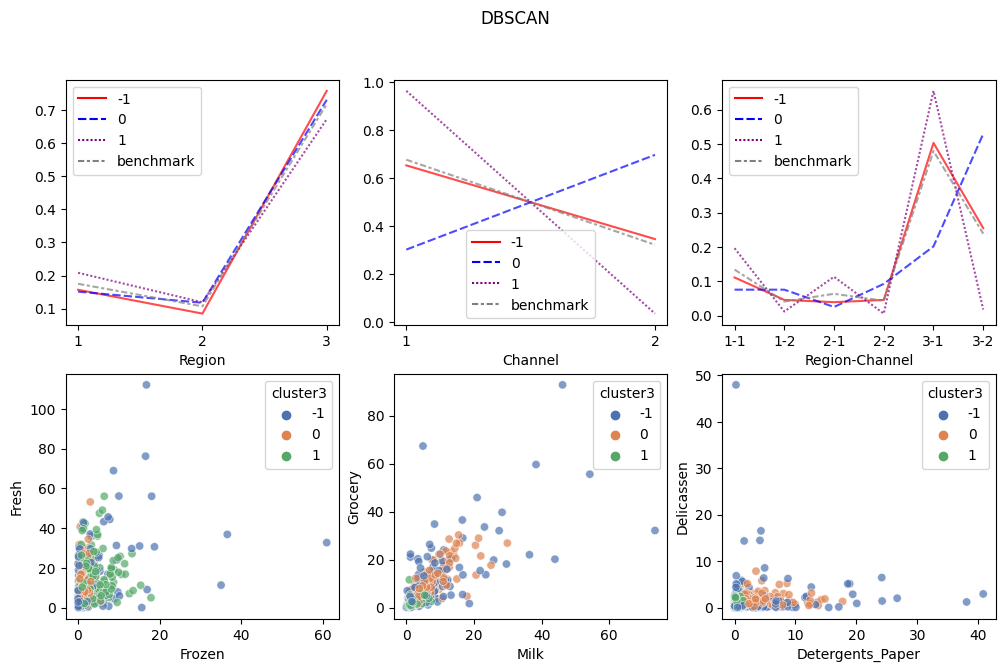

In [28]:
# visualize clustering results of DBSCAN
visualize_clusters(wholesale, "cluster3")